# Comparison between SMC-ABC, MCMC_ABC and SNPE in GLM model

In [76]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds
import lfimodels.glm.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import scripts.run_abc as run_abc

from delfi.utils.viz import plot_pdf
from lfimodels.glm.GLM import GLM
from lfimodels.glm.GLMStats import GLMStats
from mpl_toolkits.axes_grid1 import make_axes_locatable
from random import sample
from scripts.mmd import MMD_3_Sample_Test

%matplotlib inline

dirs = {}
dirs['dir_glm'] = './results/glm/'
dirs['dir_pg'] = './results/pg/'
dirs['dir_abc'] = './results/abc/'

# number of algorithms compared
n_algos = 3

## GLM model

In [77]:
seed = 42

m = GLM(seed=seed)
p = utils.smoothing_prior(n_params=m.n_params, seed=seed)
s = GLMStats(n_summary=m.n_params)
g = dg.Default(model=m, prior=p, summary=s)

true_params, labels_params = utils.obs_params()
obs = utils.obs_data(true_params, seed=seed)
obs_stats = utils.obs_stats(true_params, seed=seed)

n_params = len(true_params)
prefix = str(n_params)+'params'

# Load posteriors (1 seed, one set of hyperparameters)

## SNPE

In [78]:
n_rounds = 5
round_samp = 5000
num_sims_max = round_samp*n_rounds
n_samps = np.arange(round_samp,num_sims_max+round_samp,round_samp)

m_snpe = []
S_snpe = []

rerun = False  # if False, will try loading file from disk

try:
    assert rerun == False, 'rerun requested'
    _, _, posteriors = io.load_pkl(dirs['dir_glm'] + prefix + '_' + str(n_rounds) +'rounds_nosvi_snpe.pkl')
except:    
    seed = 1
    g = dg.Default(model=m, prior=p, summary=s)
    res = infer.SNPE(g, obs=obs_stats, pilot_samples=1000, n_hiddens=[50], seed=seed, prior_norm=True, svi=False)

    # run with N samples
    logs, trn_datasets, posteriors = res.run(round_samp, n_rounds=n_rounds, epochs=1000)
    io.save_pkl((logs, trn_datasets, posteriors),
                dirs['dir_glm'] + prefix + '_' + str(n_rounds) + 'rounds_nosvi_snpe.pkl')
    io.save(res, dirs['dir_glm'] + prefix + '_' + str(n_rounds) + 'rounds_res_nosvi_snpe.pkl')

for i in range(n_rounds):
    m1, S1 = posteriors[i].calc_mean_and_cov()
    m_snpe.append(m1)
    S_snpe.append(S1)

## PG-MCMC

In [79]:
rerun = False  # if False, will try loading file from disk

try:
    assert rerun == False, 'rerun requested'
    sam_pg = np.load(dirs['dir_pg'] + prefix + '_pg_mcmc.npz')['arr_0']
except:
    sam_pg = utils.pg_mcmc(true_params, obs, seed=None)
    np.savez(dirs['dir_pg'] + prefix + '_pg_mcmc.npz', sam_pg)

m_sam = np.mean(sam_pg,axis=1)
cov_sam = np.cov(sam_pg)

## MCMC-ABC

In [80]:
rerun = False  # if False, will try loading file from disk

try:
    assert rerun == False, 'rerun requested'
    all_ps_mcmc1, _, _, _, _ = io.load_pkl(dirs['dir_abc'] + prefix + '_mcmc_abc.pkl')
except:
    all_ps_mcmc1, stats_mcmc, dist_mcmc, acc_rate_mcmc, n_sims_mcmc = run_abc.run_mcmc(model=m, prior=p, summary=s,
                                                                                  obs_stats=obs_stats,
                                                                                  n_params=n_params, seed=None, 
                                                                                  tol=10,step=0.1,n_samples=5e6)
    io.save_pkl((all_ps_mcmc1, stats_mcmc, dist_mcmc, acc_rate_mcmc, n_sims_mcmc),
                dirs['dir_abc'] + prefix + '_mcmc_abc.pkl')
    
num_sims_max_mcmc = len(all_ps_mcmc1)
n_samps_mcmc = np.arange(round_samp,num_sims_max_mcmc,round_samp)
n_samps_mcmc[-1] = num_sims_max_mcmc

# n_burnin = 1000 # for glm with 2 parameters
# n_burnin = int(1e5)
n_burnin = 0
ps_mcmc = []
m_mcmc = []
cov_mcmc = []
for i in range(len(n_samps_mcmc)):
    if i==0:
        ps_mcmc.append(all_ps_mcmc1[0:n_samps_mcmc[i]-n_burnin,:])
    else:
        ps_mcmc.append(all_ps_mcmc1[n_samps_mcmc[i-1]-n_burnin:n_samps_mcmc[i]-n_burnin,:])    
    m_mcmc.append(np.mean(ps_mcmc[i],axis=0))
    cov_mcmc.append(np.cov(ps_mcmc[i].T))

## SMC-ABC

In [81]:
rerun = False  # if False, will try loading file from disk

try:
    assert rerun == False, 'rerun requested'
    ps_smc, logweights_smc, eps_smc, all_nsims_smc = io.load_pkl(dirs['dir_abc'] + prefix + '_smc_abc.pkl')
except:
    ps_smc, logweights_smc, eps_smc, all_nsims_smc = run_abc.run_smc(model=m, prior=p, summary=s,
                                                                                  obs_stats=obs_stats,
                                                                                  n_params=n_params, seed=None, 
                                                                                  n_particles=1e3,eps_init=15,
                                                                                  maxsim=5e6)
    io.save_pkl((ps_smc, logweights_smc, eps_smc, all_nsims_smc), dirs['dir_abc'] + prefix + '_smc_abc.pkl')

weights_smc = np.exp(logweights_smc)
nsims_smc = np.asarray(all_nsims_smc)

m_smc = []
cov_smc = []
for i in range(len(ps_smc)):
    m_smc.append(np.dot(weights_smc[i],ps_smc[i]))
    cov_smc.append(np.cov(ps_smc[i].T,aweights = weights_smc[i]))
    
all_n_sims = [n_samps,n_samps_mcmc,nsims_smc]

In [82]:
num_sims_max

25000

In [83]:
nsims_smc

array([1092840, 1103102])

In [84]:
print('maximum number of simulations for MCMC-ABC '+str(num_sims_max_mcmc))
print('maximum number of simulations for SMC-ABC '+str(nsims_smc[-1]))

maximum number of simulations for MCMC-ABC 5000001
maximum number of simulations for SMC-ABC 1103102


In [85]:
# means = np.mean(ps_mcmc[-1], axis=0)
# stds = np.std(ps_mcmc[-1], axis=0, ddof=1)
# for i in range(n_params):
#     print('w{0}: true = {1:.2} \t estimate = {2:.2} +/- {3:.2}'.format(i+1, true_params[i], means[i], 2.0 * stds[i]))

# # plot histograms and scatter plots
# viz.plot_hist_marginals(ps_mcmc[-1], lims=[-3.0, 3.0], true_params=true_params)

# # plot traces
# _, axs = plt.subplots(n_params, 1, sharex=True)
# for i in range(n_params):
#     axs[i].plot(ps_mcmc[-1][:, i])
#     axs[i].set_ylabel('w' + str(i+1))

# plt.show(block=False)

In [86]:
# for ws, logweights, eps in zip(ps_smc[-1], logweights_smc[-1], eps_smc[-1]):

#     weights = np.exp(logweights)

#     # print estimates with error bars
#     means = np.dot(weights, ws)
#     stds = np.sqrt(np.dot(weights, ws ** 2) - means ** 2)
#     print('eps = {0:.2}'.format(eps))
#     for i in range(n_params):
#         print('w{0}: true = {1:.2} \t estimate = {2:.2} +/- {3:.2}'.format(i+1, true_params[i], means[i], 2.0 * stds[i]))
#     print('')

#     # plot histograms and scatter plots
#     viz.plot_hist_marginals(ws, lims=[-3.0, 3.0], true_params=true_params)
#     plt.gcf().suptitle('tolerance = {0:.2}'.format(eps))

# plt.show(block=False)

## Plot means and variances

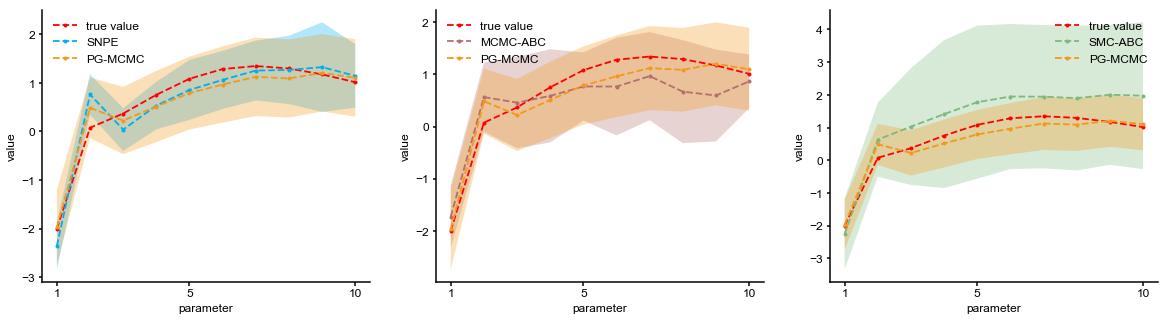

In [87]:
f, axs = plt.subplots(1,n_algos,figsize=(20,5))

COL = {}
COL['ESS']  = (244/255, 152/255, 25/255)
COL['SNPE'] = (0, 174/255,239/255)
COL['MCMC']  = (180/255, 110/255, 110/255)
COL['SMC'] = (125/255, 185/255, 125/255)

all_m = [m_snpe,m_mcmc,m_smc]
all_cov = [S_snpe,cov_mcmc,cov_smc]
all_col = [COL['SNPE'],COL['MCMC'],COL['SMC']]
all_label = ['SNPE','MCMC-ABC','SMC-ABC']

for i in range(n_algos):
    plt.subplot(1,n_algos,i+1)
    plt.fill_between(np.linspace(1, n_params, n_params), 
                     all_m[i][-1]-2*np.sqrt(np.diag(all_cov[i][-1])),
                     all_m[i][-1]+2*np.sqrt(np.diag(all_cov[i][-1])), 
                     facecolor=all_col[i], 
                     alpha=0.3)
    plt.fill_between(np.linspace(1,n_params,n_params), 
                     m_sam-2*np.sqrt(np.diag(cov_sam)),
                     m_sam+2*np.sqrt(np.diag(cov_sam)), 
                     facecolor=COL['ESS'], 
                     alpha=0.3)
    plt.plot(np.linspace(1,n_params,n_params), 
             true_params, '--o', color = 'r', label='true value')
    plt.plot(np.linspace(1,n_params,n_params), 
             all_m[i][-1], '--o', color = all_col[i], label=all_label[i])
    plt.plot(np.linspace(1,n_params,n_params),
             m_sam, '--o', color = COL['ESS'],
             label='PG-MCMC')

    plt.gca().set_xticks([1, n_params/2, n_params])
    plt.xlabel('parameter')
    plt.ylabel('value')
    plt.legend()

## Plot covariances

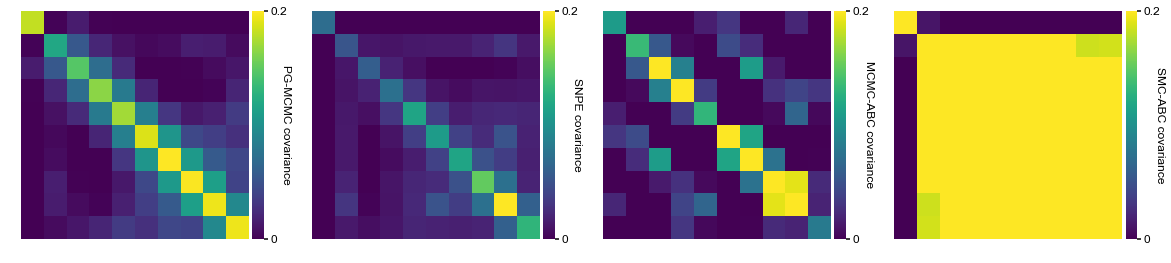

In [88]:
# min_cov = np.min([np.min(l) for l in all_cov])
# max_cov = np.max([np.max(l) for l in all_cov])
min_cov = np.min(cov_sam)
max_cov = np.max(cov_sam)

f, axs = plt.subplots(1,n_algos,figsize=(20,5))

ax = plt.subplot(1,n_algos+1,1)
im = plt.imshow(cov_sam, clim=(0, max_cov))
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('PG-MCMC covariance', rotation=270)
cb.set_clim([0, max_cov])
cb.set_ticks([0, max_cov])
cb.outline.set_visible(False)
cb.set_ticklabels(['0', str(np.round(max_cov, 1))])

for i in range(n_algos):
    ax = plt.subplot(1,n_algos+1,i+2)
    im = plt.imshow(all_cov[i][-1], clim=(0, max_cov))
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(all_label[i]+' covariance', rotation=270)
    cb.set_clim([0, max_cov])
    cb.set_ticks([0, max_cov])
    cb.outline.set_visible(False)
    cb.set_ticklabels(['0', str(np.round(max_cov, 1))])

## KL divergence between estimated and true posteriors

In [89]:
# compute KL from estimated posteriors to gaussian approximation to the sampling posterior
def gauss_kl(pm, pv, qm, qv):
    """
    Adapted from
    http://www.cs.cmu.edu/~chanwook/MySoftware/rm1_Spk-by-Spk_MLLR/rm1_PNCC_MLLR_1/rm1/python/sphinx/divergence.py
    Kullback-Liebler divergence from Gaussian qm,qv to Gaussian pm,pv.
    Divergence is expressed in nats.
    """

    # determinants of covariances pv, qv
    pv_det = np.linalg.det(pv)
    qv_det = np.linalg.det(qv)
#     print(np.log(qv_det/pv_det))

    # inverse of covariance qv
    qv_inv = np.linalg.inv(qv)
#     print(np.trace(np.dot(qv_inv,pv)))
#     print(np.dot(np.dot(qm-pm,qv_inv),qm-pm))

    return 0.5*(np.log(qv_det/pv_det) + np.trace(np.dot(qv_inv,pv))
             + np.dot(np.dot(qm-pm,qv_inv),qm-pm) - len(pm))

kl_all = np.zeros(n_algos)

for i in range(n_algos):
    kl_all[i] = gauss_kl(m_sam, cov_sam,all_m[i][-1], all_cov[i][-1])

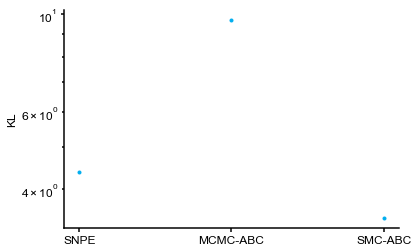

In [90]:
fig = plt.figure()
plt.semilogy(np.linspace(1, n_algos, n_algos),kl_all,'o', color=COL['SNPE'])

plt.xticks(np.linspace(1, n_algos, n_algos),all_label)
plt.ylabel('KL')

## Difference between true and estimated means and covariances (in Frobenius norm)

In [91]:
diff_m = np.zeros(n_algos)
diff_cov = np.zeros(n_algos)

for i in range(n_algos):
    diff_m[i] = np.linalg.norm(m_sam-all_m[i][-1])
    diff_cov[i] = np.linalg.norm(cov_sam-all_cov[i][-1])

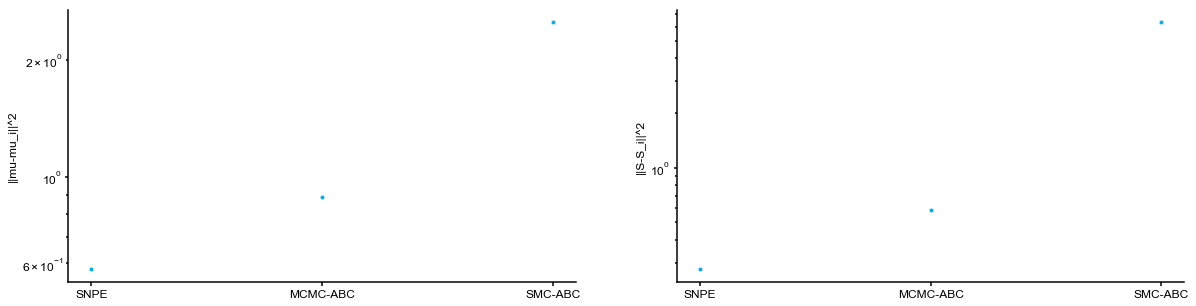

In [92]:
f, axs = plt.subplots(1,n_algos,figsize=(20,5))

ax = plt.subplot(1,2,1)
plt.semilogy(np.linspace(1, n_algos, n_algos),diff_m,'o', color=COL['SNPE'])
plt.xticks(np.linspace(1, n_algos, n_algos),all_label)
plt.ylabel('||mu-mu_i||^2')

ax = plt.subplot(1,2,2)
plt.semilogy(np.linspace(1, n_algos, n_algos),diff_cov,'o', color=COL['SNPE'])
plt.xticks(np.linspace(1, n_algos, n_algos),all_label)
plt.ylabel('||S-S_i||^2')

## Relative MMD test between algorithms. Returns a test statistic for whether Y is closer to X than Z (https://arxiv.org/pdf/1511.04581.pdf)

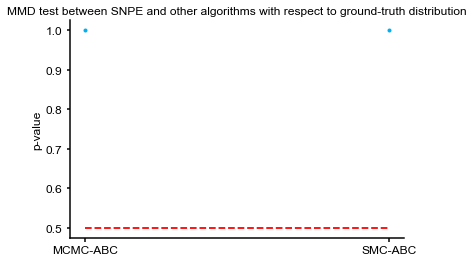

In [93]:
num_sam = 1000

sam_pg1 = sam_pg.T[sample(range(len(sam_pg.T)), num_sam)]

samp_snpe = np.random.multivariate_normal(m_snpe[-1],S_snpe[-1],num_sam)
samp_altern_mod = [ps_mcmc[-1],ps_smc[-1]]

tstat_mmd = np.zeros(n_algos-1)
pvalue_mmd = np.zeros(n_algos-1)

for i in range(n_algos-1):
    samp_altern_mod1 = samp_altern_mod[i][sample(range(len(samp_altern_mod[i])), num_sam)]
    pvalue,tstat,_,_,_= MMD_3_Sample_Test(sam_pg1,samp_snpe,samp_altern_mod1,computeMMDs=True)
    tstat_mmd[i] = tstat
    pvalue_mmd[i] = pvalue
    
fig = plt.figure()
plt.plot(np.linspace(1, n_algos-1, n_algos-1),pvalue_mmd,'o', color=COL['SNPE'])
plt.plot(np.linspace(1, n_algos-1, n_algos-1),.5+0*np.linspace(1, n_algos-1, n_algos-1),'--', color='r')
plt.xticks(np.linspace(1, n_algos-1, n_algos-1),all_label[1:])
plt.ylabel('p-value')
plt.title('MMD test between SNPE and other algorithms with respect to ground-truth distribution')

## Load posteriors (several seeds, several hyperparameters)

In [94]:
# number of algorithms compared
n_algos = 2 #3

# number of seeds
n_seeds = 5

all_m_snpe = []
all_S_snpe = []
all_sam_pg = []
all_m_sam = []
all_S_samp = []
all_ps_mcmc = []
all_m_mcmc = []
all_S_mcmc = []
all_ps_smc = []
all_m_smc = []
all_S_smc = []
all_n_sims = []

n_rounds = 5
round_samp = 5000
num_sims_max = round_samp*n_rounds
n_samps = np.arange(round_samp,num_sims_max+round_samp,round_samp)

rerun = False  # if False, will try loading file from disk

for j in range(n_seeds):  
    print(j)
    
    ################################################################################################
    # SNPE
    try:
        assert rerun == False, 'rerun requested'
        _, _, posteriors = io.load_pkl(dirs['dir_glm'] + prefix + '_' + str(n_rounds) 
                                       +'rounds_nosvi_snpe_seed'+str(j+1)+'.pkl')
    except:    
        seed = 1
        g = dg.Default(model=m, prior=p, summary=s)
        res = infer.SNPE(g, obs=obs_stats, pilot_samples=1000, n_hiddens=[50], seed=j+1, prior_norm=True, svi=False)

        # run with N samples
        logs, trn_datasets, posteriors = res.run(round_samp, n_rounds=n_rounds, epochs=1000)
        io.save_pkl((logs, trn_datasets, posteriors),
                    dirs['dir_glm'] + prefix + '_' + str(n_rounds) + 'rounds_nosvi_snpe_seed'+str(j+1)+'.pkl')
        io.save(res, dirs['dir_glm'] + prefix + '_' + str(n_rounds) + 'rounds_res_nosvi_snpe_seed'+str(j+1)+'.pkl')

    m_snpe = []
    S_snpe = []
    for i in range(n_rounds):
        m1, S1 = posteriors[i].calc_mean_and_cov()
        m_snpe.append(m1)
        S_snpe.append(S1)
        
    all_m_snpe.append(m_snpe)
    all_S_snpe.append(S_snpe)

    
    ################################################################################################
    # PG-MCMC SAMPLER
    try:
        assert rerun == False, 'rerun requested'
        sam_pg = np.load(dirs['dir_pg'] + prefix + '_pg_mcmc_seed'+str(j+1)+'.npz')['arr_0']
    except:
        sam_pg = utils.pg_mcmc(true_params, obs, seed=j+1)
        np.savez(dirs['dir_pg'] + prefix + '_pg_mcmc_seed'+str(j+1)+'.npz', sam_pg)

    m_sam = np.mean(sam_pg,axis=1)
    cov_sam = np.cov(sam_pg)
    all_sam_pg.append(sam_pg)
    all_m_sam.append(m_sam)
    all_S_samp.append(cov_sam)


    ################################################################################################
    # MCMC-ABC
    try:
        assert rerun == False, 'rerun requested'
        all_ps_mcmc1, _, _, _, _ = io.load_pkl(dirs['dir_abc'] + prefix + '_mcmc_abc_seed'+str(j+1)+'.pkl')
    except:
        all_ps_mcmc1, stats_mcmc, dist_mcmc, acc_rate_mcmc, n_sims_mcmc = run_abc.run_mcmc(model=m, prior=p, summary=s,
                                                                                      obs_stats=obs_stats,
                                                                                      n_params=n_params, seed=j+1, 
                                                                                      tol=10,step=0.1,n_samples=5e6)
        io.save_pkl((all_ps_mcmc1, stats_mcmc, dist_mcmc, acc_rate_mcmc, n_sims_mcmc),
                    dirs['dir_abc'] + prefix + '_mcmc_abc_seed'+str(j+1)+'.pkl')

    num_sims_max_mcmc = len(all_ps_mcmc1)
    n_samps_mcmc = np.arange(round_samp,num_sims_max_mcmc,round_samp)
    n_samps_mcmc[-1] = num_sims_max_mcmc

    # n_burnin = 1000 # for glm with 2 parameters
    # n_burnin = int(1e5)
    n_burnin = 0
    ps_mcmc = []
    m_mcmc = []
    cov_mcmc = []
    for i in range(len(n_samps_mcmc)):
        if i==0:
            ps_mcmc.append(all_ps_mcmc1[0:n_samps_mcmc[i]-n_burnin,:])
        else:
            ps_mcmc.append(all_ps_mcmc1[n_samps_mcmc[i-1]-n_burnin:n_samps_mcmc[i]-n_burnin,:])    
        m_mcmc.append(np.mean(ps_mcmc[i],axis=0))
        cov_mcmc.append(np.cov(ps_mcmc[i].T))
       
    all_ps_mcmc.append(ps_mcmc)
    all_m_mcmc.append(m_mcmc)
    all_S_mcmc.append(cov_mcmc)
    
    ################################################################################################
    # SMC-ABC
    try:
        assert rerun == False, 'rerun requested'
        ps_smc, logweights_smc, eps_smc, all_nsims_smc = io.load_pkl(dirs['dir_abc'] 
                                                                     + prefix + '_smc_abc_seed'+str(j+1)+'.pkl')
    except:
        ps_smc, logweights_smc, eps_smc, all_nsims_smc = run_abc.run_smc(model=m, prior=p, summary=s,
                                                                                      obs_stats=obs_stats,
                                                                                      n_params=n_params, seed=j+1, 
                                                                                      n_particles=1e3,eps_init=15,
                                                                                      maxsim=5e6)
        io.save_pkl((ps_smc, logweights_smc, eps_smc, all_nsims_smc),
                    dirs['dir_abc'] + prefix + '_smc_abc_seed'+str(j+1)+'.pkl')

    weights_smc = np.exp(logweights_smc)
    nsims_smc = np.asarray(all_nsims_smc)

    m_smc = []
    cov_smc = []
    for i in range(len(ps_smc)):
        m_smc.append(np.dot(weights_smc[i],ps_smc[i]))
        cov_smc.append(np.cov(ps_smc[i].T,aweights = weights_smc[i]))    
    
    all_ps_smc.append(ps_smc)
    all_m_smc.append(m_smc)
    all_S_smc.append(cov_smc)

#     all_n_sims.append([n_samps,n_samps_mcmc,nsims_smc])
    all_n_sims.append([n_samps,nsims_smc])

0
1
2
3
4


## Compare posteriors for different numbers of simulations

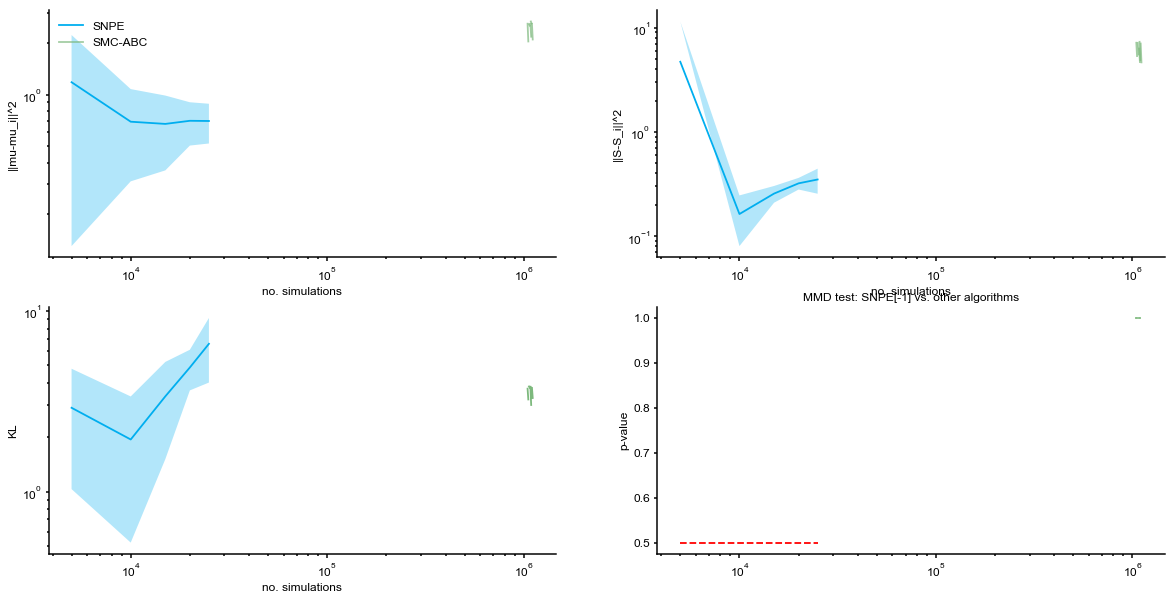

In [95]:
f, axs = plt.subplots(2,2,figsize=(20,10))

# all_seed_m = [all_m_snpe,all_m_mcmc,all_m_smc]
# all_seed_cov = [all_S_snpe,all_S_mcmc,all_S_smc]
# all_seed_sample_smcmc = [all_ps_mcmc,all_ps_smc]

all_seed_m = [all_m_snpe,all_m_smc]
all_seed_cov = [all_S_snpe,all_S_smc]
all_seed_sample_smcmc = [all_ps_smc]
all_col = [COL['SNPE'],COL['SMC']]
all_label = ['SNPE','SMC-ABC']

num_sam = 1000
sam_pg1 = []
all_samp_snpe = []
samp_altern_mod = []
for s in range(n_seeds):
    sam_pg1.append(all_sam_pg[s].T[sample(range(len(all_sam_pg[s].T)), num_sam)])

    samp_snpe = []
    for j in range(len(all_seed_m[0][s])):
        samp_snpe.append(np.random.multivariate_normal(all_m_snpe[s][j],all_S_snpe[s][j],num_sam))
    samp_altern_mod.append([all_ps_mcmc[s],all_ps_smc[s]])
    all_samp_snpe.append(samp_snpe)

for i in range(n_algos):
    diff_m_sims = []
    diff_cov_sims = []
    kl_all_seeds = []
    tstat_mmd_seeds = []
    pvalue_mmd_seeds = []
    
    for s in range(n_seeds):
        # difference between true and estimated means and covariances (in Frobenius norm)
        diff_m_sims.append(np.linalg.norm(all_m_sam[s]-all_seed_m[i][s],axis=1))
        diff_cov_sims.append(np.linalg.norm(all_S_samp[s]-all_seed_cov[i][s],axis=(1,2)))
        
        ####################################################################################################
        # KL divergence between estimated and true posteriors
        kl_all = []
        for j in range(len(all_n_sims[s][i])):
            kl_all.append(gauss_kl(all_m_sam[s], all_S_samp[s],all_seed_m[i][s][j], all_seed_cov[i][s][j]))
        kl_all_seeds.append(kl_all)
        
        ####################################################################################################
        # relative MMD test between algorithms. Returns a test statistic for whether Y is closer to X than Z
        if i>0:
            tstat_mmd = []
            pvalue_mmd = []
            for j in range(len(all_n_sims[s][i])):
                samp_altern_mod1 = samp_altern_mod[s][i-1][j][sample(range(len(samp_altern_mod[s][i-1][j])), num_sam)]
                pvalue,tstat,_,_,_= MMD_3_Sample_Test(sam_pg1[s],
                                                      all_samp_snpe[s][-1],samp_altern_mod1,computeMMDs=True)
                tstat_mmd.append(tstat)
                pvalue_mmd.append(pvalue)
            tstat_mmd_seeds.append(tstat_mmd)
            pvalue_mmd_seeds.append(pvalue_mmd)

            plt.subplot(221)
            if s<n_seeds-1:
                plt.loglog(all_n_sims[s][i],diff_m_sims[s], color=all_col[i],alpha=0.7)
            else:
                plt.loglog(all_n_sims[s][i],diff_m_sims[s], color=all_col[i],label=all_label[i],alpha=0.7)
                plt.legend()
            plt.subplot(222)
            plt.loglog(all_n_sims[s][i],diff_cov_sims[s], color=all_col[i],label=all_label[i],alpha=0.7)           
            plt.subplot(223)
            plt.loglog(all_n_sims[s][i],kl_all_seeds[s],color=all_col[i],label=all_label[i])
            if i>0:
                plt.subplot(224)
                plt.semilogx(all_n_sims[s][i],pvalue_mmd_seeds[s],color=all_col[i],label=all_label[i])
    
    if i==0:
        plt.subplot(221)
        plt.fill_between(all_n_sims[0][i], 
                     np.mean(diff_m_sims,axis=0)-2*np.std(diff_m_sims,axis=0),
                     np.mean(diff_m_sims,axis=0)+2*np.std(diff_m_sims,axis=0), 
                     facecolor=all_col[i], 
                     alpha=0.3)
        plt.loglog(all_n_sims[0][i],np.mean(diff_m_sims,axis=0), color=all_col[i],label=all_label[i])
        plt.xlabel('no. simulations')
        plt.ylabel('||mu-mu_i||^2')

        plt.subplot(222)
        plt.fill_between(all_n_sims[0][i], 
                     np.mean(diff_cov_sims,axis=0)-2*np.std(diff_cov_sims,axis=0),
                     np.mean(diff_cov_sims,axis=0)+2*np.std(diff_cov_sims,axis=0), 
                     facecolor=all_col[i], 
                     alpha=0.3)
        plt.loglog(all_n_sims[0][i],np.mean(diff_cov_sims,axis=0), color=all_col[i],label=all_label[i])
        plt.xlabel('no. simulations')
        plt.ylabel('||S-S_i||^2')

        plt.subplot(223)
        plt.fill_between(all_n_sims[0][i], 
                     np.mean(kl_all_seeds,axis=0)-2*np.std(kl_all_seeds,axis=0),
                     np.mean(kl_all_seeds,axis=0)+2*np.std(kl_all_seeds,axis=0), 
                     facecolor=all_col[i], 
                     alpha=0.3)
        plt.loglog(all_n_sims[0][i],np.mean(kl_all_seeds,axis=0),color=all_col[i],label=all_label[i])
        plt.xlabel('no. simulations')
        plt.ylabel('KL')
        
plt.subplot(224)
plt.semilogx(all_n_sims[0][0],.5+0*all_n_sims[0][0],'--', color='r')
plt.ylabel('p-value')
plt.title('MMD test: SNPE[-1] vs. other algorithms');

## Compare posteriors for different numbers of simulations (just MMD)

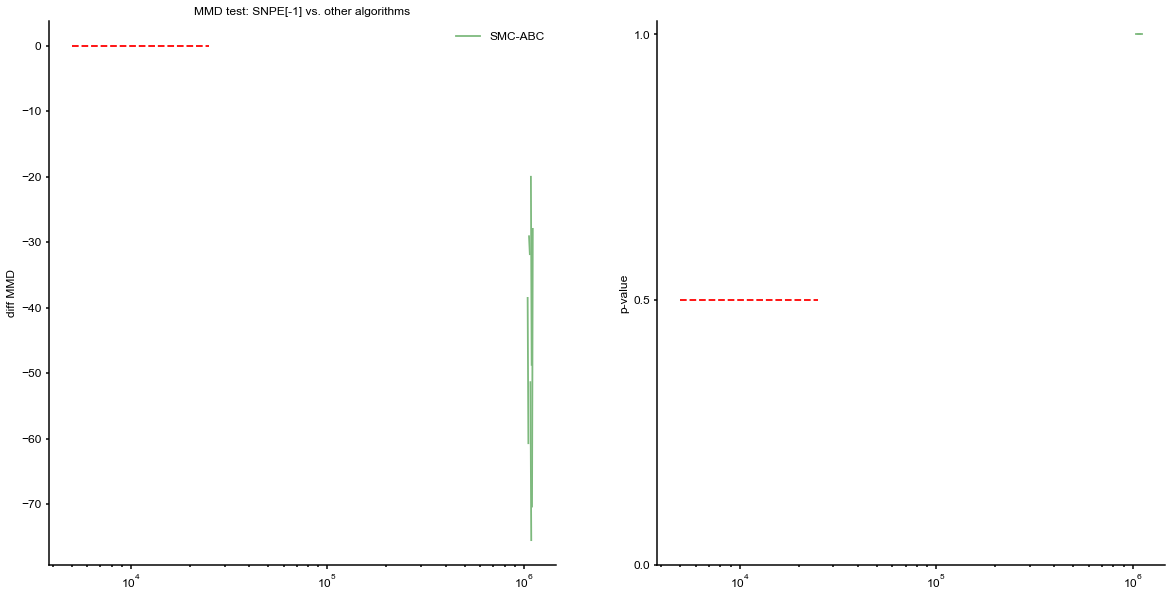

In [96]:
f, axs = plt.subplots(figsize=(20,10))

# all_seed_m = [all_m_snpe,all_m_mcmc,all_m_smc]
# all_seed_cov = [all_S_snpe,all_S_mcmc,all_S_smc]
# all_seed_sample_smcmc = [all_ps_mcmc,all_ps_smc]
all_seed_m = [all_m_snpe,all_m_smc]
all_seed_cov = [all_S_snpe,all_S_smc]
all_seed_sample_smcmc = [all_ps_smc]

for i in range(1,n_algos):
    tstat_mmd_seeds = []
    pvalue_mmd_seeds = []
    for s in range(n_seeds):
        
        # relative MMD test between algorithms. Returns a test statistic for whether Y is closer to X than Z
        tstat_mmd = []
        pvalue_mmd = []
        for j in range(len(all_n_sims[s][i])):
            samp_altern_mod1 = samp_altern_mod[s][i-1][j][sample(range(len(samp_altern_mod[s][i-1][j])), num_sam)]
            pvalue,tstat,_,_,_= MMD_3_Sample_Test(sam_pg1[s],
                                                  all_samp_snpe[s][-1],samp_altern_mod1,computeMMDs=True)
            tstat_mmd.append(tstat)
            pvalue_mmd.append(pvalue)
        tstat_mmd_seeds.append(tstat_mmd)
        pvalue_mmd_seeds.append(pvalue_mmd)
        
        if s==0:
            plt.subplot(121)
            plt.semilogx(all_n_sims[s][i],tstat_mmd_seeds[s],color=all_col[i],label=all_label[i])
        else:
            plt.subplot(121)
            plt.semilogx(all_n_sims[s][i],tstat_mmd_seeds[s],color=all_col[i])
        plt.subplot(122)
        plt.semilogx(all_n_sims[s][i],pvalue_mmd_seeds[s],color=all_col[i])

plt.subplot(121)
plt.semilogx(all_n_sims[0][0],0*all_n_sims[0][0],'--', color='r')
plt.ylabel('diff MMD')
plt.title('MMD test: SNPE[-1] vs. other algorithms')
plt.legend()

plt.subplot(122)
plt.semilogx(all_n_sims[0][0],.5+0*all_n_sims[0][0],'--', color='r')
plt.yticks([0, .5, 1])
plt.ylabel('p-value');